# Grapheme Embedding Using PyTorch

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import tqdm

import re
import numpy as np
import os
import matplotlib.pyplot as plt
from random import randint

In [3]:
text = open("data/bbc_samp.adj")
processed_text = (re.sub(r'[^\w\s]','',text.read().lower()).replace('\n',' '))
tokens = [list("$"+token+"£") for token in processed_text.split(' ')]
vocab = list('abcdefghijklmnopqrstuvwxyz$£')
v = len(vocab)
print(tokens[0])

['$', 't', 'h', 'e', '£']


In [4]:
def graph2int(graph):
    return vocab.index(graph)
    
def int2graph(index):
    return vocab[index]

def int2vec(integer):
    vec=np.zeros(len(vocab))
    vec[integer]=1
    return vec

def graph2vec(graph):
    return (int2vec(graph2int(graph)))

def vec2graph(vec):
    return (int2graph(np.argmax(vec)))

In [5]:
windowSize = 2
tokens = [tokenSet for tokenSet in tokens if len(tokenSet)>=6]
print(len(tokens))
print(tokens[0])

4413
['$', 'i', 's', 'n', 't', '£']


In [6]:
x_data = torch.empty(size=(1,2,28))
y_data = torch.empty(size=(1,4))

for word in tokens:
    wc = len(word)
    for graph_i in range(2,wc-3): 
        data_sample = torch.tensor([graph2vec(word[graph_i]), graph2vec(word[graph_i+1])]).unsqueeze(0).float()
        x_data = torch.cat([x_data,data_sample])
        
        label_sample = torch.tensor([graph2int(word[graph_i-2]), graph2int(word[graph_i-1]), 
                                         graph2int(word[graph_i+2]), graph2int(word[graph_i+3])]).unsqueeze(0).float()
        y_data = torch.cat([y_data,label_sample])
        
x_data=x_data[1:,:,:]
y_data=y_data[1:,:]

## PyTorch

### Encoder

In [7]:
class Encoder(nn.Module):
    def __init__(self,grapheme_shape,hidden_units,embedding_units):
        super(Encoder,self).__init__()
        self.word_shape = grapheme_shape
        self.hidden_units = hidden_units
        self.embedding_units = embedding_units
        
        self.weights_1 = nn.Parameter(torch.empty(size=(hidden_units, grapheme_shape), requires_grad=True))
        nn.init.normal_(self.weights_1)
        
        self.weights_2 = nn.Parameter(torch.empty(size=(embedding_units, hidden_units), requires_grad=True))
        nn.init.normal_(self.weights_2)
        
        self.bias1 = nn.Parameter(torch.zeros(hidden_units), requires_grad=True)
        self.bias2 = nn.Parameter(torch.zeros(embedding_units), requires_grad=True)

    def forward(self,inputs):
        out = F.linear(inputs, self.weights_1, self.bias1)
        out = nn.ReLU().forward(out)
        out = F.linear(out, self.weights_2,self.bias2)
        out = nn.ReLU().forward(out)
        return out
    

        

### Graph2Vec

In [8]:
class Decoder(nn.Module):
    def __init__(self,embedding_units,layer_1_n,grapheme_shape,encoder):
        super(Decoder,self).__init__()
        self.e = encoder
        self.embedding_units=embedding_units
        self.layer_1_n = layer_1_n

        self.weights_layer1 = nn.Parameter(torch.empty(size=(self.layer_1_n, self.embedding_units*2), requires_grad=True))
        nn.init.normal_(self.weights_layer1)
        self.bias_layer1 = nn.Parameter(torch.zeros(layer_1_n), requires_grad=True)

        self.weights_output2l = nn.Parameter(torch.empty(size=(grapheme_shape, self.layer_1_n), requires_grad=True))
        nn.init.normal_(self.weights_output2l)
        self.bias2l = nn.Parameter(torch.zeros(grapheme_shape), requires_grad=True)
        
        self.weights_output1l = nn.Parameter(torch.empty(size=(grapheme_shape, self.layer_1_n), requires_grad=True))
        nn.init.normal_(self.weights_output1l)
        self.bias1l = nn.Parameter(torch.zeros(grapheme_shape), requires_grad=True)
        
        self.weights_output1r = nn.Parameter(torch.empty(size=(grapheme_shape, self.layer_1_n), requires_grad=True))
        nn.init.normal_(self.weights_output1r)
        self.bias1r = nn.Parameter(torch.zeros(grapheme_shape), requires_grad=True)
        
        self.weights_output2r = nn.Parameter(torch.empty(size=(grapheme_shape, self.layer_1_n), requires_grad=True))
        nn.init.normal_(self.weights_output2r)
        self.bias2r = nn.Parameter(torch.zeros(grapheme_shape), requires_grad=True)
      
    def forward(self,inputs):
        embedding1 = self.e.forward(inputs[:,0])
        embedding2 = self.e.forward(inputs[:,1])

        out = torch.cat((embedding1,embedding2),dim=1)

        out = nn.ReLU().forward(F.linear(out, self.weights_layer1, self.bias_layer1))
        
        out2l = nn.ReLU().forward(F.linear(out, self.weights_output2l, self.bias2l))
        out1l = nn.ReLU().forward(F.linear(out, self.weights_output1l, self.bias1l))
        out1r = nn.ReLU().forward(F.linear(out, self.weights_output1r, self.bias1r))
        out2r = nn.ReLU().forward(F.linear(out, self.weights_output2r, self.bias2r))
        
        out = torch.stack((out2l,out1l,out1r,out2r),dim=1)
        return out
    
    def encode(self,inputs):
        return self.e.forward(inputs)


In [9]:
train_ratio = 0.80
batch_size = 256

trn_n = int(x_data.shape[0] * 0.8)
batches = (int(trn_n/batch_size))

x_trn = x_data[:trn_n,:,:].clone()
y_trn = y_data[:trn_n,:].clone()

x_val = x_data[trn_n:,:,:].clone()
y_val = y_data[trn_n:,:].clone()

In [11]:
metric_dict = {'losses_trn': [],'losses_val':[]} 
encoder =  Encoder(grapheme_shape=28,hidden_units=10,embedding_units=10)
decoder = Decoder(embedding_units=10,layer_1_n=15,grapheme_shape=28,encoder=encoder)
optimizer = optim.Adam(decoder.parameters(), amsgrad=False, weight_decay=0.0)

trn_loss = nn.NLLLoss()
val_loss = nn.NLLLoss()

for epoch in range(100):
    print(epoch)
    epoch_trn_loss_sum = 0
    for batch in (range(batches)):
        x_batch = x_trn[batch_size*batch:batch_size*(batch+1)]
        y_batch = y_trn[batch_size*batch:batch_size*(batch+1)]
        out = decoder.forward(x_batch).transpose(1,2)
        log_softmax = F.log_softmax(out, dim=1)
        
        print(log_softmax.shape)
        print(y_batch.shape)
        quit()
        NLL_Loss = trn_loss(log_softmax,y_batch.long()) 
        optimizer.zero_grad()
        NLL_Loss.backward()
        optimizer.step()
        epoch_trn_loss_sum += NLL_Loss.item()
        
    out_val = decoder.forward(x_val).transpose(1,2)
    log_val_softmax = F.log_softmax(out_val, dim=1)
    NLL_val_loss = trn_loss(log_val_softmax, y_val.long())
    
    epoch_trn_loss = epoch_trn_loss_sum/batches
    print(NLL_val_loss.item())
    print(epoch_trn_loss)
   # print("Val: "+str(val_loss.item()))
    metric_dict['losses_trn'].append(NLL_Loss.item())
    metric_dict['losses_val'].append(epoch_trn_loss)

0
torch.Size([256, 28, 4])
torch.Size([256, 4])
torch.Size([256, 28, 4])
torch.Size([256, 4])
torch.Size([256, 28, 4])
torch.Size([256, 4])
torch.Size([256, 28, 4])
torch.Size([256, 4])
torch.Size([256, 28, 4])
torch.Size([256, 4])
torch.Size([256, 28, 4])
torch.Size([256, 4])
torch.Size([256, 28, 4])
torch.Size([256, 4])
torch.Size([256, 28, 4])
torch.Size([256, 4])
torch.Size([256, 28, 4])
torch.Size([256, 4])
torch.Size([256, 28, 4])
torch.Size([256, 4])
torch.Size([256, 28, 4])
torch.Size([256, 4])
torch.Size([256, 28, 4])
torch.Size([256, 4])
torch.Size([256, 28, 4])
torch.Size([256, 4])
torch.Size([256, 28, 4])
torch.Size([256, 4])
torch.Size([256, 28, 4])
torch.Size([256, 4])
torch.Size([256, 28, 4])
torch.Size([256, 4])
torch.Size([256, 28, 4])
torch.Size([256, 4])
torch.Size([256, 28, 4])
torch.Size([256, 4])
torch.Size([256, 28, 4])
torch.Size([256, 4])
torch.Size([256, 28, 4])
torch.Size([256, 4])
torch.Size([256, 28, 4])
torch.Size([256, 4])
torch.Size([256, 28, 4])
torch.S

torch.Size([256, 28, 4])
torch.Size([256, 4])
torch.Size([256, 28, 4])
torch.Size([256, 4])
torch.Size([256, 28, 4])
torch.Size([256, 4])
torch.Size([256, 28, 4])
torch.Size([256, 4])
torch.Size([256, 28, 4])
torch.Size([256, 4])
torch.Size([256, 28, 4])
torch.Size([256, 4])
torch.Size([256, 28, 4])
torch.Size([256, 4])
torch.Size([256, 28, 4])
torch.Size([256, 4])
torch.Size([256, 28, 4])
torch.Size([256, 4])
torch.Size([256, 28, 4])
torch.Size([256, 4])
torch.Size([256, 28, 4])
torch.Size([256, 4])
torch.Size([256, 28, 4])
torch.Size([256, 4])
torch.Size([256, 28, 4])
torch.Size([256, 4])
torch.Size([256, 28, 4])
torch.Size([256, 4])
torch.Size([256, 28, 4])
torch.Size([256, 4])
torch.Size([256, 28, 4])
torch.Size([256, 4])
torch.Size([256, 28, 4])
torch.Size([256, 4])
8.537853240966797
9.175937243870326
6
torch.Size([256, 28, 4])
torch.Size([256, 4])
torch.Size([256, 28, 4])
torch.Size([256, 4])
torch.Size([256, 28, 4])
torch.Size([256, 4])
torch.Size([256, 28, 4])
torch.Size([256, 

torch.Size([256, 28, 4])
torch.Size([256, 4])
torch.Size([256, 28, 4])
torch.Size([256, 4])
torch.Size([256, 28, 4])
torch.Size([256, 4])
torch.Size([256, 28, 4])
torch.Size([256, 4])
torch.Size([256, 28, 4])
torch.Size([256, 4])
torch.Size([256, 28, 4])
torch.Size([256, 4])
torch.Size([256, 28, 4])
torch.Size([256, 4])
torch.Size([256, 28, 4])
torch.Size([256, 4])
torch.Size([256, 28, 4])
torch.Size([256, 4])
torch.Size([256, 28, 4])
torch.Size([256, 4])
torch.Size([256, 28, 4])
torch.Size([256, 4])
torch.Size([256, 28, 4])
torch.Size([256, 4])
torch.Size([256, 28, 4])
torch.Size([256, 4])
torch.Size([256, 28, 4])
torch.Size([256, 4])
torch.Size([256, 28, 4])
torch.Size([256, 4])
torch.Size([256, 28, 4])
torch.Size([256, 4])
torch.Size([256, 28, 4])
torch.Size([256, 4])
torch.Size([256, 28, 4])
torch.Size([256, 4])
torch.Size([256, 28, 4])
torch.Size([256, 4])
torch.Size([256, 28, 4])
torch.Size([256, 4])
torch.Size([256, 28, 4])
torch.Size([256, 4])
torch.Size([256, 28, 4])
torch.Siz

torch.Size([256, 28, 4])
torch.Size([256, 4])
torch.Size([256, 28, 4])
torch.Size([256, 4])
torch.Size([256, 28, 4])
torch.Size([256, 4])
torch.Size([256, 28, 4])
torch.Size([256, 4])
torch.Size([256, 28, 4])
torch.Size([256, 4])
torch.Size([256, 28, 4])
torch.Size([256, 4])
torch.Size([256, 28, 4])
torch.Size([256, 4])
torch.Size([256, 28, 4])
torch.Size([256, 4])
torch.Size([256, 28, 4])
torch.Size([256, 4])
torch.Size([256, 28, 4])
torch.Size([256, 4])
torch.Size([256, 28, 4])
torch.Size([256, 4])
torch.Size([256, 28, 4])
torch.Size([256, 4])
torch.Size([256, 28, 4])
torch.Size([256, 4])
torch.Size([256, 28, 4])
torch.Size([256, 4])
torch.Size([256, 28, 4])
torch.Size([256, 4])
torch.Size([256, 28, 4])
torch.Size([256, 4])
torch.Size([256, 28, 4])
torch.Size([256, 4])
torch.Size([256, 28, 4])
torch.Size([256, 4])
torch.Size([256, 28, 4])
torch.Size([256, 4])
3.506739377975464
3.491652945109776
17
torch.Size([256, 28, 4])
torch.Size([256, 4])
torch.Size([256, 28, 4])
torch.Size([256,

KeyboardInterrupt: 

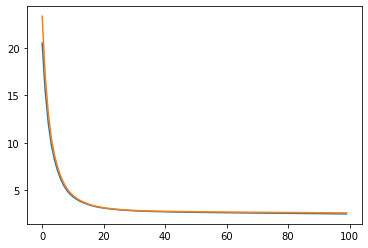

In [15]:
plt.plot(metric_dict['losses_trn'][:100])
plt.plot(metric_dict['losses_val'][:100])

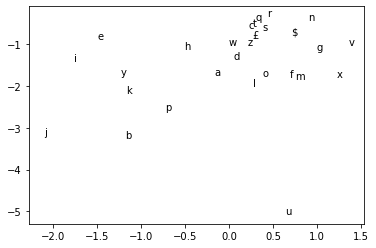

In [850]:
embeddings = np.zeros(shape=(len(vocab),10))

i=0
for grapheme in vocab:
    test = torch.from_numpy(graph2vec(grapheme)).float()
    embedding = decoder.encode(test).detach().numpy()
    embeddings[i,:]=embedding
    i+=1

embedding_means = embeddings.mean(axis=0)
embedding_std = embeddings.std(axis=0)
norm_embeddings = (embeddings-embedding_means)/embedding_std

    
covariance_matrix = np.cov(norm_embeddings.T)
v,w = np.linalg.eig(covariance_matrix)

idx = v.argsort()[::-1] # Sort descending and get sorted indices
v = v[idx] # Use indices on eigv vector
w = w[:,idx] # 

variance_explained = []
for i in v:
     variance_explained.append((i/sum(v))*100)
        
red_Vecs = w[0:2,:]

low_d_embed = (embeddings @ red_Vecs.T)

#plt.scatter(x=low_d_embed[:,0],y=low_d_embed[:,1])

x=low_d_embed[:,0]
y=low_d_embed[:,1]

fig, ax = plt.subplots()
ax.scatter(x, y,color='white')

for i, txt in enumerate(vocab):
    ax.annotate(txt, (x[i], y[i]))

In [24]:
n=randint(0,x_trn.shape[0])

input = x_trn[n,:,:].unsqueeze(0)
output = y_trn[n,:]

out=decoder.forward(input).transpose(1,2)
log_softmax = -F.log_softmax(out, dim=1)

p=(log_softmax.argmin(dim=1).detach().numpy()[0])
o=(output.int().numpy())

numpy_input = input.int().detach().numpy()[0]
inp_ind = (numpy_input.argmax(axis=1))
inp_let = [vocab[i] for i in inp_ind]
pred = [vocab[i] for i in p]
outp = [vocab[i] for i in o]
print(inp_let)
print(''.join(pred[0:2])+''.join(inp_let)+''.join(pred[2:]))
print(''.join(outp[0:2])+''.join(inp_let)+''.join(outp[2:]))

['a', 't']
$eate£
$late£


In [849]:
embeddings = np.zeros(shape=(len(vocab),10))

i=0
for grapheme in vocab:
    test = torch.from_numpy(graph2vec(grapheme)).float()
    embedding = decoder.encode(test).detach().numpy()
    embeddings[i,:]=embedding
    i+=1
    
l=0
for e in (embeddings):
    dists=(np.square(embeddings-e).sum(axis=1))
    nearest_idx=(np.argsort(dists)[1])
    print("Nearest neighbour of "+vocab[l]+" : "+vocab[nearest_idx])
    l+=1
    

Nearest neighbour of a : c
Nearest neighbour of b : p
Nearest neighbour of c : f
Nearest neighbour of d : z
Nearest neighbour of e : s
Nearest neighbour of f : x
Nearest neighbour of g : q
Nearest neighbour of h : r
Nearest neighbour of i : k
Nearest neighbour of j : w
Nearest neighbour of k : i
Nearest neighbour of l : d
Nearest neighbour of m : x
Nearest neighbour of n : r
Nearest neighbour of o : a
Nearest neighbour of p : b
Nearest neighbour of q : s
Nearest neighbour of r : n
Nearest neighbour of s : t
Nearest neighbour of t : s
Nearest neighbour of u : b
Nearest neighbour of v : $
Nearest neighbour of w : $
Nearest neighbour of x : f
Nearest neighbour of y : t
Nearest neighbour of z : £
Nearest neighbour of $ : v
Nearest neighbour of £ : z
